In [39]:
import numpy as np
import torch
import torch.autograd as autograd         # 计算图（用于构建张量的自动求导关系）
from torch import Tensor                  # 计算图中的张量节点（用于存储数据和梯度信息）
import torch.nn as nn                     # 神经网络模块（提供网络层、激活函数等）
import torch.optim as optim               # 优化器模块（如梯度下降、ADAM等优化算法）
import time
from pyDOE import lhs         # 拉丁超立方抽样（一种空间填充抽样方法）
import matplotlib.pyplot as plt
import matplotlib.ticker

# 设置默认数据类型为float32
torch.set_default_dtype(torch.float)

# PyTorch随机数生成器（设置种子以保证结果可复现）
torch.manual_seed(1234)

# 其他库的随机数生成器（设置种子以保证结果可复现）
np.random.seed(1234)

# 设备配置（自动选择GPU（CUDA）或CPU进行计算）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# 如果使用CUDA设备，打印对应的GPU设备名称
if device == 'cuda': print(torch.cuda.get_device_name())


import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'    #允许库重复加载

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认中文字体
plt.rcParams['axes.unicode_minus'] = False

cuda


In [40]:
x_1 = np.linspace(-1,1,256)  # 在区间[-1, 1]上生成256个等间距的点，形状为[256×1]
x_2 = np.linspace(1,-1,256)  # 在区间[1, -1]上生成256个等间距的点（即从1递减到-1），形状为[256×1]

X, Y = np.meshgrid(x_1,x_2)  # 利用x_1和x_2生成网格点坐标矩阵，X和Y分别对应网格的横、纵坐标矩阵

In [41]:
# 将X和Y按列优先（Fortran顺序）展平为一维数组，再转换为列向量后水平拼接（得到测试点坐标矩阵）
# 形状说明：展平后为[N×1]，拼接后为[N×2]（N=256×256，两列分别对应X、Y坐标）
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# 求解域边界
lb = np.array([-1, -1]) # 下界（对应X、Y坐标的最小值）
ub = np.array([1, 1])  # 上界（对应X、Y坐标的最大值）

a_1 = 1 
a_2 = 1

k = 1

# 解析解（人为选取该形式用于验证模型效果，方便后续对比预测值与真实值）
# 计算网格上每个点对应的真实解值，形状与X、Y一致（[256×256]）
usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y)  

# 将网格形式的解析解按列优先（Fortran顺序）展平为一维列向量，形状为[N×1]（N=256×256）
u_true = usol.flatten('F')[:,None]

生成训练数据

In [43]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    # 从完整边界数据集中随机选取N_u个训练点
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] # 根据索引选取坐标训练数据
    u_train = all_u_train[idx[0:N_u],:]      # 根据索引选取对应真实解标签
    
    '''配点'''

    # 拉丁超立方抽样生成配点
    # N_f个(x,y)坐标对
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # 将训练点拼接到配点中
    
    return X_f_train, X_u_train, u_train

PINN处理函数

In [45]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):             #初始化函数
        super().__init__() # 调用父类的__init__方法
              
        '激活函数'
        self.activation = nn.Tanh()

        '损失函数'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        '使用nn.ModuleList将神经网络初始化为一个列表'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # 标准差 = 增益 * sqrt(2/(输入维度+输出维度))
        for i in range(len(layers)-1):
            
            # 权重从正态分布中采样
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # 将偏置初始化为0
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):             #向前传播
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        # 输入数据预处理
        x = (x - l_b)/(u_b - l_b) # 特征缩放
        
        # 转换为浮点型
        a = x.float()
                              
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):                 #边界条件损失
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f):              #PDE残差损失
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx = autograd.grad(u_x,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_xx_1 = u_xx[:,[0]]
        
        u_xx_2 = u_xx[:,[1]]
                
        q = ( -(a_1*np.pi)**2 - (a_2*np.pi)**2 + k**2 ) * torch.sin(a_1*np.pi*x_1_f) * torch.sin(a_2*np.pi*x_2_f)
                        
        f = u_xx_1 + u_xx_2 + k**2 * u - q 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):                 #总损失函数

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    '供优化器调用的函数'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_u_train, u_train, X_f_train)
        
        error_vec, _ = PINN.test()
        
        print(loss,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):                   #测试评估函数
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # 误差的相对L2范数（向量形式）
        
        u_pred = np.reshape(u_pred.cpu().detach().numpy(),(256,256),order='F')                 
        
        return error_vec, u_pred

绘图

In [47]:
def solutionplot(u_pred, X_u_train, u_train):
    """
    绘制解的比较图：真实解、预测解和绝对误差
    """
    # 真实解
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('真实解 $u(x_1,x_2)$', fontsize=15)

    # 预测解
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('预测解 $\hat u(x_1,x_2)$', fontsize=15)

    # 绝对误差
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'绝对误差 $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)

    # 保存图像
    #plt.savefig('Helmholtz_non_stiff.png', dpi=500, bbox_inches='tight')
    plt.show() 

主函数

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
tensor(84.4532, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0493, device='cuda:0', grad_fn=<DivBackward0>)
tensor(67.1843, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6813, device='cuda:0', grad_fn=<DivBackward0>)
tensor(40.7814, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1749, device='cuda:0', grad_fn=<DivBackward0>)
tensor(35.5308, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7335, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19.4513, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4607, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.6673, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.1794, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.1694, device='cuda:0', grad_fn

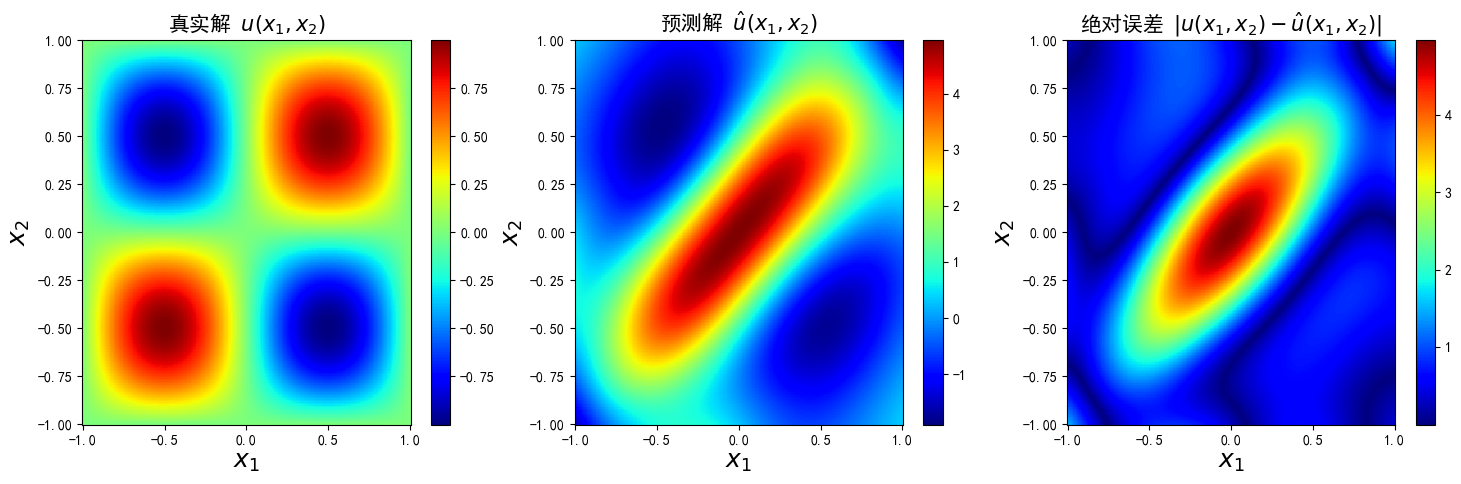

'\nprint("准备绘图...")\nprint(f"x_1 形状: {x_1.shape}, x_2 形状: {x_2.shape}")\nprint(f"真实解u_sol形状: {usol.shape}, 预测解u_pred形状: {u_pred.shape}")\n\n# 计算内存占用\nif hasattr(usol, \'nbytes\'):\n    total_memory = (usol.nbytes + u_pred.nbytes + x_1.nbytes + x_2.nbytes) / 1e3\n    print(f"总内存占用约: {total_memory:.2f} KB")\n'

In [49]:
N_u = 400  # 变量'u'的总数据点数量
N_f = 10000  # 配点的总数量 

# 训练数据
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

# 转换为张量并发送到GPU
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2, 50, 50, 50, 1])  # 3个隐藏层

PINN = Sequentialmodel(layers)
       
PINN.to(device)

# 神经网络结构摘要

print(PINN)

params = list(PINN.parameters())

optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 500  # 最大迭代次数

start_time = time.time()  # 记录训练开始时间

for i in range(max_iter):

    loss = PINN.loss(X_u_train, u_train, X_f_train)  # 计算损失值
           
    optimizer.zero_grad()     # 清空所有参数的梯度缓存
    
    loss.backward()  # 反向传播计算梯度

    optimizer.step()  # 更新模型参数
    
    # 每迭代1/10的总次数，打印一次损失值和测试误差
    if i % (max_iter/10) == 0:

        error_vec, _ = PINN.test()

        print(loss,error_vec)
    
    
elapsed = time.time() - start_time  # 计算训练总耗时              
print('训练时间: %.2f' % (elapsed))


''' 模型精度评估 ''' 
error_vec, u_pred = PINN.test()

print('测试误差: %.5f'  % (error_vec))

solutionplot(u_pred,X_u_train,u_train)  # 绘制解决方案对比图

''' 解决方案可视化绘图 '''

'''
print("准备绘图...")
print(f"x_1 形状: {x_1.shape}, x_2 形状: {x_2.shape}")
print(f"真实解u_sol形状: {usol.shape}, 预测解u_pred形状: {u_pred.shape}")

# 计算内存占用
if hasattr(usol, 'nbytes'):
    total_memory = (usol.nbytes + u_pred.nbytes + x_1.nbytes + x_2.nbytes) / 1e3
    print(f"总内存占用约: {total_memory:.2f} KB")
'''